# Integrated normal flux

This notebook demonstrates and tests the `intnormalflux` method for TimML models.

This method integrates the flux normal to a line along that line. Two integration methods are implemented:
- numerical integration using `scipy.optimize.quad_vec`
- analytic approximation of the integral using Legendre polynomials


In [1]:
# import packages
import numpy as np
import timml as tml
import matplotlib.pyplot as plt

## Uniform flow field

First, we perform some simple sanity checks in a uniform flow field.

Number of elements, Number of equations: 2 , 1
..
solution complete


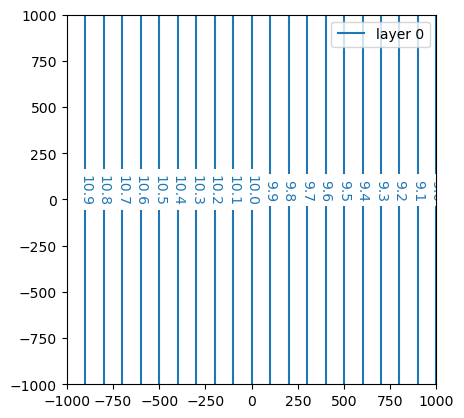

In [2]:
slope = 0.001  # head gradient in m/m

ml = tml.ModelMaq()
u = tml.Uflow(ml, slope, angle=0.0)
c = tml.Constant(ml, 0.0, 0.0, 10)
ml.solve()
ml.contour([-1000, 1000, -1000, 1000], decimals=1);

We define a line between $(-10, -10)$ and $(10, 10)$ which has a 45 degree angle relative to the positive x-axis. The integrated flux along this line should equal $L \cdot \cos(\theta) \cdot \text{slope}$.

Since we have defined Q as positive when flowing to the left when going from 
$(x_1, y_1)$ to $(x_2, y_2)$, `intfluxnorm` will return a negative flux, but the absolute value should match our calculation. 


In [3]:
x1, y1 = -10.0, -10.0
x2, y2 = 10.0, 10.0
L = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
theta = np.arctan2(y2 - y1, x2 - x1)

qn_quad = ml.intnormflux(x1, y1, x2, y2, method="quad")
qn_leg = ml.intnormflux(x1, y1, x2, y2, method="legendre", ndeg=3)

print(np.round(np.array([qn_quad[0], qn_leg[0], L * np.cos(theta) * slope]), 4))

[-0.02 -0.02  0.02]


Next we define a line normal to the head gradient. The integrated normal flux along that should equal the length of the line multiplied by the gradient: $L \cdot \text{slope}$. Once again our integrated flux is negative since we define flow to the left as positive when integrating from $(x_1, y_1)$ to $(x_2, y_2)$.

In [4]:
x1, y1 = 0.0, -10.0
x2, y2 = 0.0, 10.0
L = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

qn_quad = ml.intnormflux(x1, y1, x2, y2, method="quad")
qn_leg = ml.intnormflux(x1, y1, x2, y2, method="legendre", ndeg=3)

print(np.round(np.array([qn_quad[0], qn_leg[0], L * slope]), 4))

[-0.02 -0.02  0.02]


For a line parallel to the head gradient the integrated flux normal to the line should equal 0.

In [5]:
x1, y1 = -10.0, 0.0
x2, y2 = 10.0, 0.0

qn_quad = ml.intnormflux(x1, y1, x2, y2, method="quad")
qn_leg = ml.intnormflux(x1, y1, x2, y2, method="legendre", ndeg=3)

print(np.round(np.array([qn_quad[0], qn_leg[0], 0.0]), 4))

[-0. -0.  0.]


## Two layer confined model with well

In this next example we create a model with two layers with a confined top and a well in the bottom layer that pumps 500 $m^3/d$.


Number of elements, Number of equations: 2 , 1
..
solution complete


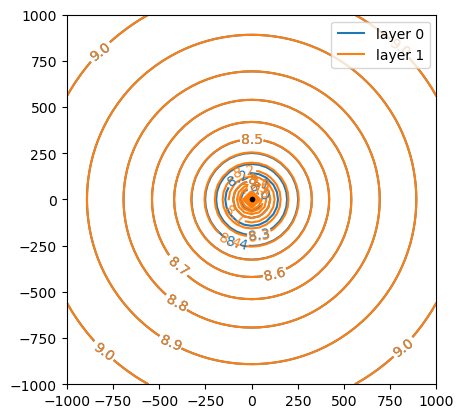

In [6]:
ml = tml.ModelMaq(kaq=[5.0, 10.0], z=[0, -10, -15, -30], c=[100])
c = tml.Constant(ml, 1e4, 1e4, 10)
w = tml.Well(ml, 0.0, 0.0, Qw=500, layers=[1])
ml.solve()
ml.contour(
    [-1000, 1000, -1000, 1000],
    levels=np.arange(6.0, 9.5, 0.1),
    ngr=51,
    layers=[0, 1],
    decimals=1,
);

Plot the head along radial distance $r$ for both layers.

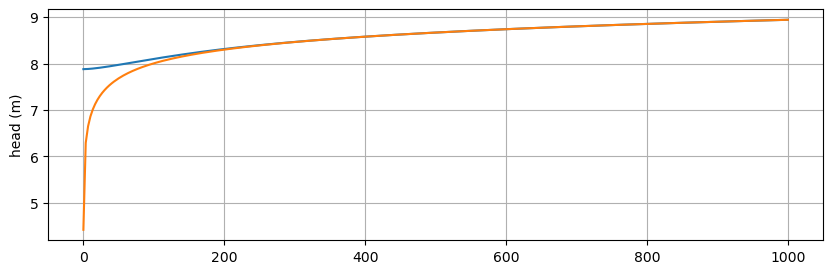

In [7]:
xl = np.linspace(0.1, 1000, 301)
yl = np.zeros_like(xl)

h = ml.headalongline(xl, yl)

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(xl, h[0], color="C0")
ax.plot(xl, h[1], color="C1")
ax.set_ylabel("head (m)")
ax.grid(True)

Define two arbitrary polygons along which we will calculate the total net inflow using `intnormflux`. One polygon contains the well, the other does not.

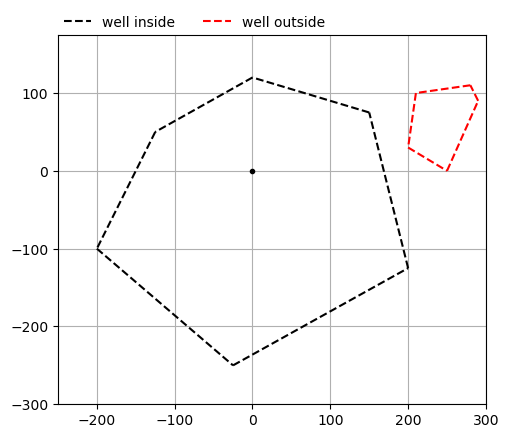

In [8]:
xy_in = [
    (-200, -100),
    (-25, -250),
    (200, -125),
    (150, 75),
    (0, 120),
    (-125, 50),
    (-200, -100),
]

xy_out = [
    (250, 0),
    (290, 90),
    (280, 110),
    (210, 100),
    (200, 30),
    (250, 0),
]

window = [-250, 300, -300, 175]
ml.plot(window)
for i in range(len(xy_in) - 1):
    xyi = np.array(xy_in[i : i + 2])
    (p1,) = plt.plot(xyi[:, 0], xyi[:, 1], ls="dashed", color="k", label="well inside")
for i in range(len(xy_out) - 1):
    xyi = np.array(xy_out[i : i + 2])
    (p2,) = plt.plot(xyi[:, 0], xyi[:, 1], ls="dashed", color="r", label="well outside")
plt.legend(
    [p1, p2], [p1.get_label(), p2.get_label()], loc=(0, 1), frameon=False, ncol=2
)
plt.grid(True)

Integration of the normal flux along edges of the polygon with the well inside shows that the total inflow along the shape is equal to $Q_w$. Both integration methods (quad and legendre) yield similar results.

In [9]:
Qn_quad = np.zeros(ml.aq.naq)
Qn_leg = np.zeros(ml.aq.naq)

for i in range(len(xy_in) - 1):
    x1, y1 = xy_in[i]
    x2, y2 = xy_in[i + 1]

    qni_quad = ml.intnormflux(x1, y1, x2, y2, method="quad")
    qni_leg = ml.intnormflux(x1, y1, x2, y2, method="legendre", ndeg=7)

    Qn_quad += qni_quad
    Qn_leg += qni_leg

print("Q (quad)    :", Qn_quad.sum())
print("Q (legendre):", Qn_leg.sum())

Q (quad)    : 500.0000000000002
Q (legendre): 500.0000023231959


Integration of the normal flux along the edges of the polygon with no well inside equals 0. Any water flowing in must by definition also flow out.

In [10]:
Qn_quad = np.zeros(ml.aq.naq)
Qn_leg = np.zeros(ml.aq.naq)

for i in range(len(xy_out) - 1):
    x1, y1 = xy_out[i]
    x2, y2 = xy_out[i + 1]

    qni_quad = ml.intnormflux(x1, y1, x2, y2, method="quad")
    qni_leg = ml.intnormflux(x1, y1, x2, y2, method="legendre", ndeg=7)

    Qn_quad += qni_quad
    Qn_leg += qni_leg

print("Q (quad)    :", Qn_quad.sum())
print("Q (legendre):", Qn_leg.sum())

Q (quad)    : -8.881784197001252e-16
Q (legendre): -8.393286066166183e-14
